# Approximate Bayesian inference
This notebook demonstrates how to compute various approximations of the Fisher information matrix from (pre-trained) PyTorch models (e.g. *torchvision* models pretrainted on ImageNet) which can be used as preconditioners in second-order optimization or to perform approximate Bayesian inference.

In [1]:
# Standard imports
import os
import copy
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from matplotlib import pyplot as plt
%matplotlib inline

# From the repository
import fisher
from sampling import invert_factors, sample_and_replace_weights
from utils import calibration_curve
import plot

## Preliminaries
After import a required modules, let's define some helper functions, the model and data we want to use and train the model (or use a pre-trained one).

In [2]:
# Change this to 'cuda' if you have a working GPU.
device = 'cpu'

def train(model, data, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for images, labels in tqdm(data):
            logits = model(images.to(device))

            loss = criterion(logits, labels.to(device))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
def eval(model, data):
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor()

    with torch.no_grad():
        for images, labels in tqdm(data):
            logits = torch.cat([logits, model(images.to(device))])
            targets = torch.cat([targets, labels])
    return torch.nn.functional.softmax(logits, dim=1), targets

def accuracy(predictions, labels):
    print(f"Accuracy: {100 * np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.numpy()):.2f}%")

In [3]:
# Define a PyTorch model (or load a pretrained one).
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# This tutorial uses a LeNet-5 variant.
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, 5, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(6, 16, 5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)).to(device)

In [4]:
# Load some data for training
torch_data = "~/.torch/datasets"  # Standard PyTorch dataset location
train_set = torchvision.datasets.MNIST(root=torch_data,
                                       train=True,
                                       transform=torchvision.transforms.ToTensor(),
                                       download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

# And some for evaluating/testing
test_set = torchvision.datasets.MNIST(root=torch_data,
                                      train=False,
                                      transform=torchvision.transforms.ToTensor(),
                                      download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256)

In [5]:
# Train the model (or load a pretrained one)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, criterion, optimizer, epochs=3)

100%|██████████| 1875/1875 [00:27<00:00, 68.93it/s]


In [6]:
# Evaluate the model (optional)
sgd_predictions, sgd_labels = eval(model, test_loader)
accuracy(sgd_predictions, sgd_labels)

100%|██████████| 40/40 [00:01<00:00, 27.56it/s]

Accuracy: 96.85%


## The diagonal Fisher information matrix (IM)
Now we can compute the simplest curvature approximation: The diagonal Fisher information matrix (IM). This is done in a very similar way to a standard PyTorch training loop, except that we sample our labels from the output distribution
of the trained model to obtain the IM instead of the 'empirical' IM which uses labels from the data distribution and replace the optimizer by the update of our curvature estimator.

This will give a rank-1 approximation of the IM. If a better approximation is desired, use more samples from the model output distribution.

In [7]:
model.train()
diag = fisher.DIAG(model)

for images, labels in tqdm(train_loader):
    logits = model(images.to(device))
    dist = torch.distributions.Categorical(logits=logits)
    
    # A rank-10 diagonal IM approximation.
    for sample in range(10):
        labels = dist.sample()
        
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward(retain_graph=True)

        diag.update(batch_size=images.size(0))

100%|██████████| 1875/1875 [00:38<00:00, 48.71it/s]


## Kronecker factorization
We can also compute the Kronecker factored IM (KFAC). The module interface is exactly the same.

In [8]:
kfac = fisher.KFAC(model)

for images, labels in tqdm(train_loader):
    logits = model(images.to(device))
    dist = torch.distributions.Categorical(logits=logits)
    
    # A rank-1 Kronecker factored IM approximation.
    labels = dist.sample()
    
    loss = criterion(logits, labels)
    model.zero_grad()
    loss.backward()
    
    kfac.update(batch_size=images.size(0))

100%|██████████| 1875/1875 [00:13<00:00, 134.32it/s]


# Eigenvalue correction
To compute the sparse information form of the IM, we first need to compute the eigenvalue corrected diagonal (EFB), which in turn requires the KFAC factors.

In [9]:
factors = list(kfac.state.values())
efb = fisher.EFB(model, factors)

for images, labels in tqdm(train_loader):
    logits = model(images.to(device))
    dist = torch.distributions.Categorical(logits=logits)
    
    for sample in range(10):
        labels = dist.sample()
        
        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward(retain_graph=True)
    
        efb.update(batch_size=images.size(0))

100%|██████████| 1875/1875 [00:49<00:00, 37.73it/s]


# Sparse Information Form
The final step is the computation of the diagonal correction term D. This does not involve any data. Further, we can choose the rank of the approximation.

In [10]:
lambdas = list(efb.state.values())
diags = list(diag.state.values())
inf = fisher.INF(factors, lambdas, diags)
inf.accumulate(rank=100)

100%|██████████| 5/5 [00:00<00:00, 25.54it/s]


# Inversion and Sampling
By inverting the IM approximation, we obtain an approximate weight posterior distribution of our model. Because the approximation is inaccurate, we need to regularize it with the two hyperparameters `N` (scale) and `tau` (norm).

To transform our model into a Baysian Neural Network (BNN), we can now simply sample weights from the approximate posterior. Instead of single forward pass, we than perform multiple and average the results referred to as 'approximate Bayesian inference' or 'Monte Carlo integration'.

In [11]:
estimator = 'inf'
norm = 1e8
scale = 2e10
inv_factors = invert_factors(inf.state, norm, scale, estimator)

In [12]:
posterior_mean = copy.deepcopy(model.state_dict())
mean_predictions = 0
samples = 10  # 10 Monte Carlo samples from the weight posterior.

with torch.no_grad():
    for sample in range(samples):
        sample_and_replace_weights(model, inv_factors, estimator)
        predictions, labels = eval(model, test_loader)
        mean_predictions += predictions
        model.load_state_dict(posterior_mean)
    mean_predictions /= samples
    
accuracy(mean_predictions, labels)

100%|██████████| 40/40 [00:00<00:00, 41.43it/s]

Accuracy: 95.88%


# Calibration
The obtained averaged model output can now be compared against the single determinstic forward pass of the standard model. Here we only have a look at the calibration. For this simple model and dataset, the baseline is already very well calibrated and there is practically no difference between the it and the Bayesian model, especially as we did not perform any hyperparameter search.

In [13]:
ece_nn = calibration_curve(sgd_predictions.cpu().numpy(), sgd_labels.numpy())[0]
ece_bnn = calibration_curve(mean_predictions.cpu().numpy(), labels.numpy())[0]
print(f"ECE NN: {100 * ece_nn:.2f}%, ECE BNN: {100 * ece_bnn:.2f}%")

ECE NN: 0.61%, ECE BNN: 0.65%


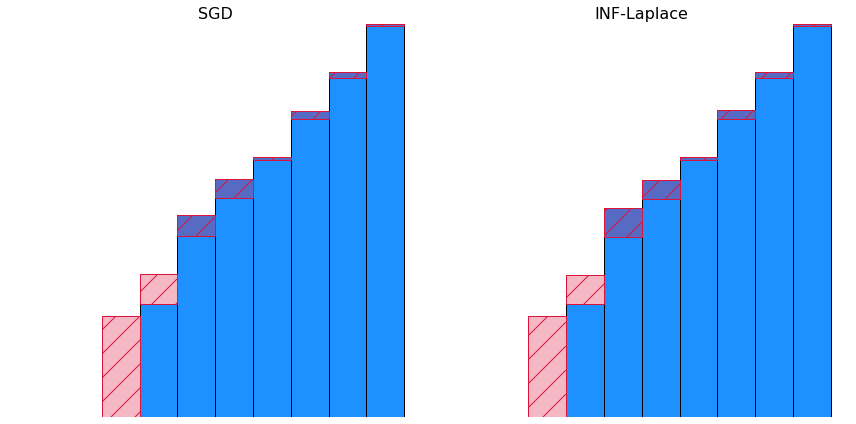

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), tight_layout=True)
ax[0].set_title('SGD', fontsize=16)
ax[1].set_title('INF-Laplace', fontsize=16)
plot.reliability_diagram(sgd_predictions.cpu().numpy(), sgd_labels.numpy(), axis=ax[0])
plot.reliability_diagram(mean_predictions.cpu().numpy(), labels.numpy(), axis=ax[1])

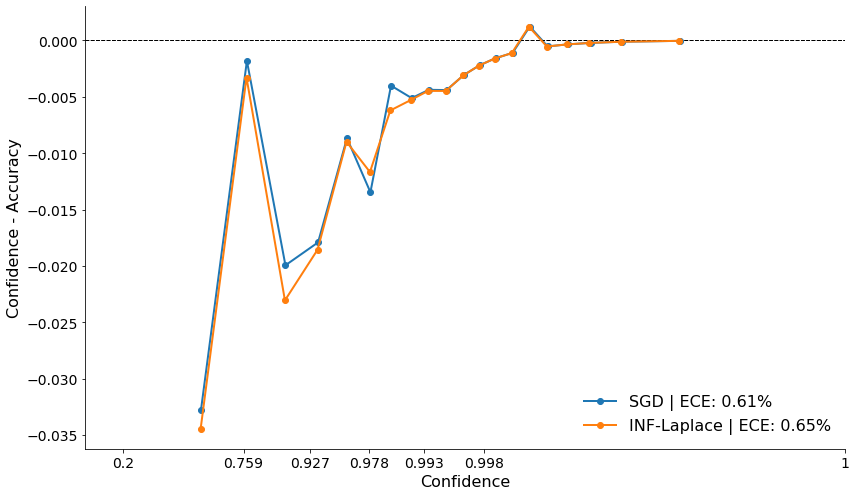

In [15]:
fig, ax = plt.subplots(figsize=(12, 7), tight_layout=True)
c1 = next(ax._get_lines.prop_cycler)['color']
c2 = next(ax._get_lines.prop_cycler)['color']
plot.calibration(sgd_predictions.cpu().numpy(), sgd_labels.numpy(), color=c1, label="SGD", axis=ax)
plot.calibration(mean_predictions.cpu().numpy(), labels.numpy(), color=c2, label="INF-Laplace", axis=ax)
plt.show()